In [1]:
# reload modules before running
%load_ext autoreload
%autoreload

In [2]:
import argparse, os, re, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Simulate running model as with 00train_model.py
os.chdir(Path.home() / 'Code/Python/tensormorph')
sys.path.append('../phon')
sys.path.append('./tensormorph')
from tensormorph import *

print('imported')

imported


In [4]:
# Initialize environment
args_ = {
         'data': 'chamorro_um',
         'features': 'hayes_features.csv',
         'morphosyn': 'unimorph',
         'dmorphophon': 1,
         'reduplication': False,
         'config': 'model_config.yaml'}
args = argparse.Namespace(**args_)
config = tensormorph.init(args)
form_embedder = config.form_embedder
decoder = config.decoder

FileNotFoundError: [Errno 2] No such file or directory: '../tensormorph_data/chamorro_um.pkl'

In [6]:
# Syllable parsing
from syllable_parser import SyllableParser
stem_str = ['plana']
stem_str = form_embedder.string2delim(stem_str, split=True)
print(stem_str)
stem_tpr = form_embedder.string2tpr(stem_str, delim=False)
stem_tpr = torch.stack(stem_tpr, 0)
parser = SyllableParser()
parse = parser(stem_tpr)
print(stem_tpr[0,0])
print(parse[0,:,5])

['⋊ p l a n a ⋉']
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([9.9999e-06, 9.9999e-06, 9.9999e-06, 9.9998e-01, 9.9998e-01, 9.9996e-06,
        9.9995e-01])


In [7]:
# Test hardtanh0
X = torch.randn(10, 5)
Y = tpr.hardtanh0(X)
Y = torch.nn.functional.hardtanh(X, 1.0e-5, 1.0 - 1.0e-5)
print(Y)
epsilon = 1.0e-8
print(epsilon, 1.0 - epsilon)

tensor([[8.1868e-01, 9.9165e-01, 1.0000e-05, 1.5852e-01, 9.9999e-01],
        [5.0558e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.2991e-02],
        [1.0000e-05, 1.0000e-05, 9.9999e-01, 1.0000e-05, 1.0000e-05],
        [9.9999e-01, 9.9999e-01, 3.5174e-01, 1.0000e-05, 1.0000e-05],
        [1.0000e-05, 1.9632e-01, 8.5453e-01, 1.0000e-05, 1.0000e-05],
        [3.6939e-01, 1.0000e-05, 1.0000e-05, 6.1499e-01, 1.0000e-05],
        [1.0000e-05, 2.1364e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01],
        [1.0000e-05, 1.0000e-05, 2.5909e-01, 7.3471e-01, 1.0000e-05],
        [7.4903e-01, 1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05],
        [2.9183e-01, 9.1507e-01, 1.0000e-05, 1.0000e-05, 3.9428e-01]])
1e-08 0.99999999


(992, 594)
[0.14495465 0.12523335 0.06191334 0.05126672 0.04550602 0.04230608
 0.03890761 0.03485286 0.03292575 0.03089131 0.02703037 0.02361351
 0.02243636 0.02014586 0.01879907 0.01791086 0.01680283 0.01550622
 0.01341977 0.01264882 0.01157484 0.01134122 0.01081999 0.00934625
 0.00888498 0.00868666 0.00855821 0.00801604 0.00750875 0.00704708
 0.00656265 0.00601416 0.00540607 0.00517483 0.00503255 0.00478805
 0.00460408 0.00417959 0.00390774 0.0037834  0.00373071 0.00352173
 0.00332783 0.00308895 0.00279675 0.00272131 0.00252663 0.0024619
 0.00239872 0.00227537]
[0.14495465 0.270188   0.33210135 0.38336807 0.4288741  0.47118017
 0.5100878  0.54494065 0.5778664  0.6087577  0.635788   0.65940154
 0.6818379  0.70198375 0.7207828  0.73869365 0.7554965  0.7710027
 0.78442246 0.7970713  0.80864614 0.81998736 0.8308073  0.8401536
 0.84903854 0.8577252  0.8662834  0.87429947 0.8818082  0.8888553
 0.8954179  0.9014321  0.9068382  0.912013   0.91704553 0.9218336
 0.9264377  0.9306173  0.934525 

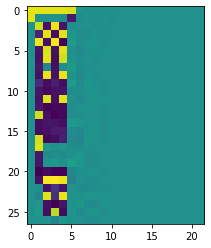

In [34]:
# Dimensionality reduction of TPRs (xxx try convolutional autoencoder)
from sklearn.decomposition import PCA
X = [ex['stem'] for ex in config.dat_train]
X = torch.stack(X, dim = 0)
nbatch, dsym, nrole = X.shape
X_ = X.view(nbatch, -1).data.numpy()
print(X_.shape)

pca = PCA(n_components = 50)
pca.fit(X_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
#print(pca.singular_values_)

Y_ = pca.transform(X_)
Z_ = pca.inverse_transform(Y_)
Z_ = torch.tensor(Z_, dtype=torch.float)
print(Y_.shape, Z_.shape)

Zi = Z_[0].view(dsym, nrole)
plt.imshow(Zi.data)
print(morph.Morph(form = X[0].unsqueeze(0))._str())
print(morph.Morph(form = Zi.unsqueeze(0))._str())

In [21]:
# ----- fix me -----
# Hand-wired infixation
stem_str = ['planta']
stem_str = form_embedder.string2delim(stem_str, split=True)
stem = Morph(form_str = stem_str)
stem.pivot = torch.zeros((1,config.nrole))
stem.copy = torch.zeros((1,config.nrole))
stem.pivot[:,2] = 1.0
stem.copy[:,:stem.length[0]] = 1.0

affix_str = ['um']
affix_str = form_embedder.string2sep(affix_str)
affix = Morph(form_str = affix_str)
affix.pivot = torch.zeros((1,config.nrole))
affix.copy = torch.zeros((1,config.nrole))
affix.pivot[:,1] = 1.0
affix.copy[:,:affix.length[0]] = 1.0

morph_op = MorphOp()
config.posn_attender.tau.data[:] = 2.0
config.morph_attender.tau.data[:] = 2.0
output = morph_op(stem, affix)
output_str = decoder.decode2string(output.form)[0]
print(f'combine({stem.form_str[0]}, {affix.form_str[0]})  ->  {output_str}')

fix, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(stem.form[0])
ax[1].imshow(affix.form[0])
ax[2].imshow(output.form.detach()[0])
plt.show()

AttributeError: 'NoneType' object has no attribute 'to'

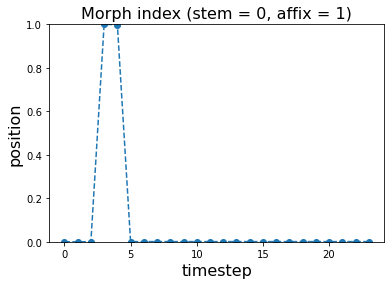

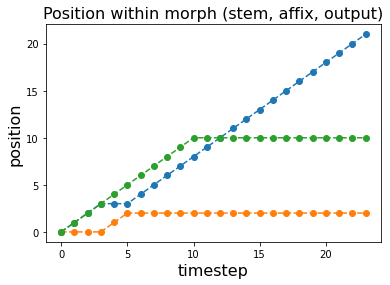

In [6]:
morph_a = torch.cat(morph_op.trace['a'], -1)[0]
stem_b = torch.cat(stem.trace['b'], -1)[0]
affix_b = torch.cat(affix.trace['b'], -1)[0]
output_b = torch.cat(output.trace['b'], -1)[0]
#tstep = torch.arange(config.nrole)

fig,ax = plt.subplots(1); ax.set_ylim(0,1)
ax.plot(morph_a, 'o--')
ax.set_title('Morph index (stem = 0, affix = 1)', fontsize=16)
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('position', fontsize=16)
plt.show()

fig,ax = plt.subplots(1) #; ax.set_ylim(0,12)
for b in [stem_b, affix_b, output_b]:
    ax.plot(b, 'o--')
ax.set_title('Position within morph (stem, affix, output)', fontsize=16)
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('position', fontsize=16)
plt.show()

In [22]:
# Hand-wired root-and-pattern
root_str = ['ktb']
root_str = config.form_embedder.string2delim(root_str, split=True)
root = Morph(form_str = root_str)
root.pivot = torch.zeros((1, config.nrole))
root.copy = torch.zeros((1, config.nrole))
root.pivot.data[0,1] = 1.0
root.pivot.data[0,3] = 1.0
root.copy.data[0,:root.length[0]] = 1.0

affix_str = ['au']
affix_str = config.form_embedder.string2sep(affix_str)
affix = Morph(form_str = affix_str,)
affix.pivot = torch.zeros((1, config.nrole))
affix.copy = torch.zeros((1, config.nrole))
affix.pivot.data[0,:2] = 1.0
affix.copy.data[0,:affix.length[0]] = 1.0

output = morph_op(root, affix)
plt.imshow(output.form.detach()[0])
output_str = decoder.decode2string(output.form)
print(f'combine({root.form_str[0]}, {affix.form_str[0]}) -> {output_str[0]}')

AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:
# ----- fix me -----

In [4]:
# Hand-wired reduplication
grammar = config.grammar
cogrammar = grammar.cogrammar
base_cogrammar = cogrammar.base_cogrammar
red_cogrammar = cogrammar.red_cogrammar
decoder = grammar.decoder

par_vec = torch.nn.utils.parameters_to_vector(
    grammar.parameters())
print(f'total parameters: {par_vec.shape[0]}')

cogrammar.pivoter.init(ftr='end', before=True)
# xxx unpivoter

bias = 3.0
base_cogrammar.affixer.init(bias=bias)
base_cogrammar.truncater.init(bias=bias)

red_cogrammar.affixer.init(bias=bias)
red_cogrammar.truncater.init(delete_before=False, delete_begin=True, delete_end=False, bias=bias)
red_cogrammar.truncater.pivoter.init(direction='LR->', ftr='V', before=False, bias=bias)

tau = 2.0
for cogram in [cogrammar, base_cogrammar, red_cogrammar]:
    cogram.combiner.morph_attender.tau.data.fill_(tau)
    cogram.combiner.posn_attender.tau.data.fill_(tau)
decoder.tau.data.fill_(tau)

Output = cogrammar(Stem, Morphosyn)
plt.imshow(Output[0].detach(), origin='upper', aspect='auto')
output = decoder.decode(Output)
output_seg = config.form_embedder.idvec2string(output[0], trim=True)
print(output_seg)

total parameters: 1318


AttributeError: 'Affixer' object has no attribute 'context2affix'

⋊ b a p o ⋉


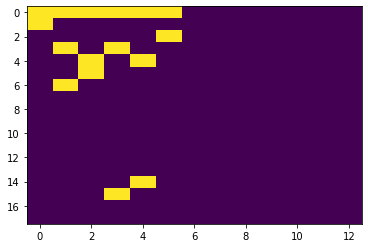

In [63]:
config.recoder = Recorder()
recorder = config.recorder

grammar = config.grammar
cogrammar = grammar.cogrammar
affixer = cogrammar.affixer
decoder = grammar.decoder

tau = 2.0 # 2.0 is sufficient for very precise attention
cogrammar.combiner.morph_attender.tau.data.fill_(tau)
cogrammar.combiner.posn_attender.tau.data.fill_(tau)
decoder.tau.data.fill_(tau)

datapoint = config.val_dat[0]
stem = datapoint['stem']
Stem = datapoint['Stem'].unsqueeze(0)
Morphosyn = datapoint['Morphosyn'].unsqueeze(0)

#stem = '⋊ b a p o j i ⋉'
#Stem = config.form_embedder.string2tpr(stem, delim=False).unsqueeze(0)
print(stem)
plt.imshow(Stem[0].detach(), origin='upper', aspect='auto')

Pivoter
Parameter containing:
tensor([10.,  0.,  0.,  0.,  0.])
Parameter containing:
tensor([10.,  0.,  0.,  0.,  0.])
tensor([[4.5612e-05, 4.5389e-05, 2.2695e-05, 1.1197e-07, 2.2476e-05, 2.2420e-05,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]], grad_fn=<AddBackward0>)

Affix
Parameter containing:
tensor([-10., -10., -10., -10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
         10.])
Parameter containing:
tensor([ 10.,  10.,  10.,  10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -10.])
tensor([[10., 10., 10., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 10.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

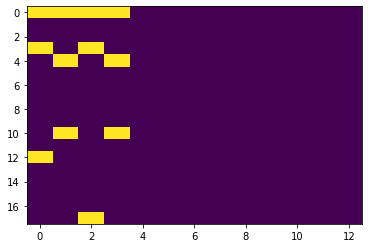

tensor([[2.4825e-03, 2.4764e-03, 2.4477e-03, 2.4192e-03, 9.8757e-01, 4.4837e-05,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]], grad_fn=<AddBackward0>)

Affixed output
tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], grad_fn=<SelectBackward>)
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

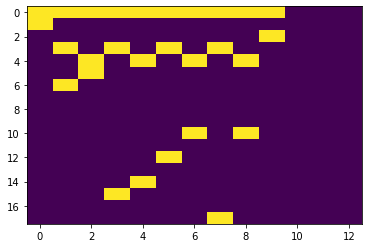

⋊ b a p o k i w i ⋉


In [16]:
# Test initialization
# Pivot initialization
print('Pivoter')
affixer.pivoter.init()
print(affixer.pivoter.pivoter_LR.context2alpha.bias)
print(affixer.pivoter.pivoter_RL.context2alpha.bias)
pivot = affixer.pivoter(Stem, Morphosyn)
print(pivot[0])
#plt.imshow(affixer.pivoter.bias.detach(), origin='upper', aspect='auto')
print()

# Affix initialization
print('Affix')
affixer.init(affix='k i w i')
affixer.pivoter.init(ftr='end', before=1)
print(affixer.context2unpivot.bias)
print(affixer.context2affix_copy.bias)
affix = affixer.context2affix.bias.detach().\
            view(config.dfill, config.nrole)
print(affix)
plt.imshow(affix.detach(), origin='upper', aspect='auto')
plt.show()
pivot = affixer.pivoter(Stem, Morphosyn)
print(pivot[0])
print()

# Affixation
print('Affixed output')
config.recorder = Recorder()
cogrammar.truncater.init(delete_before=0)
print(cogrammar.truncater(Stem, Morphosyn)[0])
Output = cogrammar(Stem, Morphosyn, max_len=10)
print(np.round(Output[0].detach(),2))
plt.imshow(Output[0].detach(), origin='upper', aspect='auto')
plt.show()
output = decoder.decode(Output)
output_seg = config.form_embedder.idvec2string(output[0])
print(output_seg)

tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
tensor([2.4825e-03, 2.4764e-03, 2.4477e-03, 2.4192e-03, 9.8757e-01, 4.4837e-05,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00])
tensor([[0.0000, 0.9994, 1.9987, 2.9981, 3.9974, 4.9967, 4.9973, 4.9980, 4.9986,
         4.9993, 5.0000, 5.9994]])


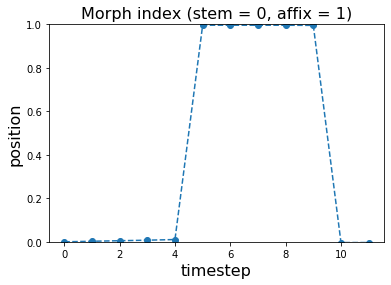

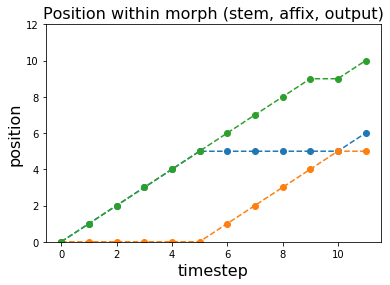

tensor([[9.9991e-01],
        [9.9991e-01],
        [9.9986e-01],
        [9.9984e-01],
        [9.9984e-01],
        [9.9919e-01],
        [9.9918e-01],
        [9.9917e-01],
        [9.9917e-01],
        [9.9916e-01],
        [9.9916e-01],
        [6.2289e-04]])
torch.Size([12, 1])


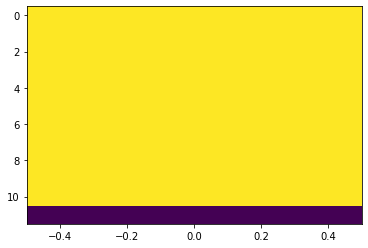

In [17]:
record = config.recorder.dump(save=False)
print(record['root-cogrammar-copy_stem'][0].t())
print(record['root-cogrammar-pivot'][0].t())
print(record['root-cogrammar-combiner-stem_indx'][0].t())

fig,ax = plt.subplots(1); ax.set_ylim(0,1)
ax.plot(record['root-cogrammar-combiner-morph_indx'][0].detach(), 'o--')
ax.set_title('Morph index (stem = 0, affix = 1)', fontsize=16)
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('position', fontsize=16)
plt.show()

fig,ax = plt.subplots(1); ax.set_ylim(0,12)
ax.plot(record['root-cogrammar-combiner-stem_indx'][0].detach(), 'o--')
ax.plot(record['root-cogrammar-combiner-affix_indx'][0].detach(), 'o--')
ax.plot(record['root-cogrammar-combiner-output_indx'][0].detach(), 'o--')
ax.set_title('Position within morph (stem, affix, output)', fontsize=16)
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('position', fontsize=16)
plt.show()

fig,ax = plt.subplots(1)
delta0 = record['root-cogrammar-combiner-writer-delta0'][0]
print(delta0)
print(delta0.shape)
ax.imshow(delta0.detach(), aspect='auto')

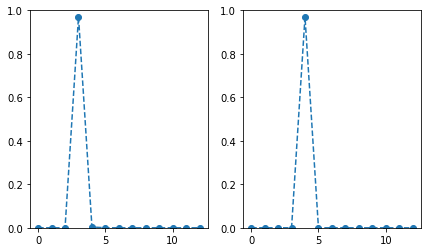

⋊ b a p o ⋉  ->  ⟨⋊⟩ ⟨b⟩ ⟨a⟩ ⟨p⟩ o ⟨⋉⟩  ->  o ε ε ε ε ε ε ε ε ε ε ε ε


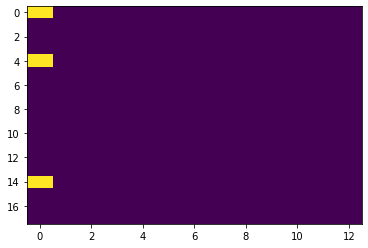

In [5]:
# Truncation example
tau = 10.0
cogrammar = grammar.cogrammar
decoder = grammar.decoder
affixer = cogrammar.affixer
affixer.pivoter.init() # don't pivot
truncater = cogrammar.truncater
truncater.init(delete_before=1, delete_begin=1, delete_end=1)
truncater.pivoter.init(direction='<-RL', ftr='V')

#recorder.init()
pivot_vec, _, _ = truncater.pivoter(Stem, Morphosyn)
copy_vec = truncater(Stem, Morphosyn)
fig,ax = plt.subplots(1, 2, figsize=(7,4))
ax[0].set_ylim(0,1); ax[1].set_ylim(0,1)
ax[0].plot(pivot_vec.detach()[0], 'o--')
ax[1].plot(copy_vec.detach()[0], 'o--')
plt.show()

#recorder.init()
cogrammar.combiner.morph_attender.tau.data.fill_(tau)
cogrammar.combiner.posn_attender.tau.data.fill_(tau)
Trunc = cogrammar(Stem, Morphosyn, max_len=10)
plt.imshow(Trunc[0].detach(), origin='upper', aspect='auto')

#recorder.init()
decoder.tau.data.fill_(tau)
stem_ = decoder.decode(Stem)
stem_seg = config.form_embedder.idvec2string(stem_[0], copy=copy_vec[0])
trunc = decoder.decode(Trunc)
trunc_seg = config.form_embedder.idvec2string(trunc[0])
print(stem, ' -> ', stem_seg, ' -> ', trunc_seg)

In [7]:
pivoter1_pars = pivoter1.state_dict()
state_dict_new = {
    'matcher.context2Wpos.weight': torch.tensor([0.0, 0.0, 0.0, 0.0, 3.0]).unsqueeze(1),
    'matcher.context2Wpos.bias': torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
    'matcher.context2Wneg.weight': torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0]).unsqueeze(1),
    'matcher.context2Wneg.bias': torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
    'matcher.context2tau.weight': torch.tensor([1.0,]).reshape(1,1),
    'matcher.context2tau.bias': torch.tensor([0.0,]),
    'context2tau.weight': torch.tensor([1.0,]).reshape(1,1),
    'context2tau.bias': torch.tensor([0.0,]),
    'context2alpha.weight': torch.tensor([3.0,]).reshape(1,1),
    'context2alpha.bias': torch.tensor([0.0,]),
    'context2beta.weight': torch.tensor([3.0,]).reshape(1,1),
    'context2beta.bias': torch.tensor([0.0,])    
}
pivoter1.load_state_dict(state_dict_new)
if 0:
    for p,v in pivoter1_pars.items():
        print(p,v)

pivot = pivoter1(Stem, Morph)[0].detach().numpy()[0][0:15]
print(pivot)
#print(pivot)
#print(stem)
fig, ax = plt.subplots(1)
plt.plot(pivot)
ax.set_ylim(0,0.5)
plt.show()
print(stem)

print(config.recorder.record)

RuntimeError: Error(s) in loading state_dict for BiPivoter:
	Missing key(s) in state_dict: "pivoter_LR.context2alpha.weight", "pivoter_LR.context2alpha.bias", "pivoter_LR.context2beta.weight", "pivoter_LR.context2beta.bias", "pivoter_LR.matcher.context2Wpos.weight", "pivoter_LR.matcher.context2Wpos.bias", "pivoter_LR.matcher.context2Wneg.weight", "pivoter_LR.matcher.context2Wneg.bias", "pivoter_LR.matcher.context2tau.weight", "pivoter_LR.matcher.context2tau.bias", "pivoter_RL.context2alpha.weight", "pivoter_RL.context2alpha.bias", "pivoter_RL.context2beta.weight", "pivoter_RL.context2beta.bias", "pivoter_RL.matcher.context2Wpos.weight", "pivoter_RL.matcher.context2Wpos.bias", "pivoter_RL.matcher.context2Wneg.weight", "pivoter_RL.matcher.context2Wneg.bias", "pivoter_RL.matcher.context2tau.weight", "pivoter_RL.matcher.context2tau.bias". 
	Unexpected key(s) in state_dict: "context2tau.weight", "context2tau.bias", "context2beta.weight", "context2beta.bias". 
	size mismatch for matcher.context2Wpos.weight: copying a param with shape torch.Size([5, 1]) from checkpoint, the shape in current model is torch.Size([1, 1]).
	size mismatch for matcher.context2Wpos.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for matcher.context2Wneg.weight: copying a param with shape torch.Size([5, 1]) from checkpoint, the shape in current model is torch.Size([1, 1]).
	size mismatch for matcher.context2Wneg.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([1]).

In [8]:
#help(pivoter.FixedPivoter)
pivoter2 = pivoter.FixedPivoter(1, 5, 1, state_dict_new)
pivot = pivoter2(Stem, Morph)[0].detach().numpy()[0][0:15]
print(pivot)
#print(pivot)
#print(stem)
fig, ax = plt.subplots(1)
plt.plot(pivot)
ax.set_ylim(0,0.5)
plt.show()
print(stem)

RuntimeError: Error(s) in loading state_dict for FixedPivoter:
	size mismatch for context2alpha.weight: copying a param with shape torch.Size([1, 1]) from checkpoint, the shape in current model is torch.Size([5, 1]).
	size mismatch for context2alpha.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for context2beta.weight: copying a param with shape torch.Size([1, 1]) from checkpoint, the shape in current model is torch.Size([5, 1]).
	size mismatch for context2beta.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for matcher.context2Wpos.weight: copying a param with shape torch.Size([5, 1]) from checkpoint, the shape in current model is torch.Size([1, 1]).
	size mismatch for matcher.context2Wpos.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for matcher.context2Wneg.weight: copying a param with shape torch.Size([5, 1]) from checkpoint, the shape in current model is torch.Size([1, 1]).
	size mismatch for matcher.context2Wneg.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([1]).

In [15]:
match = config.recorder.record['root-cogrammar-affixer-pivoter-match']
scan_LR = config.recorder.record['root-cogrammar-affixer-pivoter-scan_LR']
print(match)
print(scan_LR)
W_LR = pivoter.inhibiter.W_LR
W_RL = pivoter.inhibiter.W_RL
match2 = torch.exp(torch.log(match) + match @ W_LR)
print(match2)
match3 = match * torch.exp(torch.exp(torch.FloatTensor([1,])) * match @ W_LR)
print(match3)

tensor([[0.0516, 0.0516, 0.0516, 0.1691, 0.0516, 0.0516, 0.1691, 0.0516, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0516, 0.0449, 0.0390, 0.1110, 0.0214, 0.0186, 0.0529, 0.0102, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0516, 0.0490, 0.0466, 0.1449, 0.0374, 0.0355, 0.1103, 0.0284, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0516, 0.0449, 0.0390, 0.1110, 0.0214, 0.0186, 0.0529, 0.0102, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


In [16]:
Wpos_weight = 1.0 * state_dict_new['matcher.context2Wpos.weight']
Wpos_bias = state_dict_new['matcher.context2Wpos.bias']
Wneg_weight = 1.0 * state_dict_new['matcher.context2Wneg.weight']
Wneg_bias = state_dict_new['matcher.context2Wneg.bias']

#Wpos = torch.relu(Wpos_weight) + torch.sigmoid(Wpos_weight) # + Wpos_bias.unsqueeze(1))
#Wneg = torch.relu(Wneg_weight) + torch.sigmoid(Wneg_weight) # + Wneg_bias.unsqueeze(1))
Wpos = torch.nn.functional.softplus(Wpos_weight - 5.0)
Wneg = torch.nn.functional.softplus(Wneg_weight - 5.0)
print(Wpos, Wneg)

def dist1(X, Wpos, Wneg):
    nfeature = Wpos.shape[0]
    val = Wpos * (X.narrow(1,0,nfeature) - 1.0)**2.0 + \
          Wneg * (X.narrow(1,0,nfeature) + 1.0)**2.0
    val = torch.sum(val,1)
    #val = val**0.5
    return val

def dist2(X, Wpos, Wneg):
    nfeature = Wpos.shape[0]
    val = torch.sum(Wpos * X.narrow(1,0,nfeature), 1) + \
          torch.sum(-Wneg * X.narrow(1,0,nfeature), 1)
    return val

dist = dist1(Stem, Wpos, Wneg)
match = torch.exp(-dist)
print(dist)
print(match)
#log_match = -dist(Stem, Wpos, Wneg)
#print(log_match)
#match = torch.exp(5.0 * log_match)
#print(match)

tensor([[0.0067],
        [0.0067],
        [0.0067],
        [0.0067],
        [0.1269]]) tensor([[0.0067],
        [0.0067],
        [0.0067],
        [0.0067],
        [0.0067]])
tensor([[0.2142, 0.2142, 0.2142, 0.0940, 0.2142, 0.2142, 0.0940, 0.2142, 0.1874,
         0.1874, 0.1874, 0.1874, 0.1874, 0.1874, 0.1874, 0.1874, 0.1874, 0.1874,
         0.1874, 0.1874, 0.1874, 0.1874, 0.1874, 0.1874, 0.1874, 0.1874]])
tensor([[0.8072, 0.8072, 0.8072, 0.9103, 0.8072, 0.8072, 0.9103, 0.8072, 0.8291,
         0.8291, 0.8291, 0.8291, 0.8291, 0.8291, 0.8291, 0.8291, 0.8291, 0.8291,
         0.8291, 0.8291, 0.8291, 0.8291, 0.8291, 0.8291, 0.8291, 0.8291]])


In [17]:
log_match1 = config.recorder.record['root-cogrammar-affixer-pivoter-matcher-log_match']
match2 = torch.softmax(log_match1, 1)
print(match2)
#match2 = torch.exp(match1)
inhib_LR = match2 @ W_LR
match3 = torch.log(match2) + inhib_LR
print(match3)
match4 = torch.softmax(match3, 1)
print(match4)

tensor([[0.0797, 0.0797, 0.0797, 0.2610, 0.0797, 0.0797, 0.2610, 0.0797, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[-2.5297, -2.6094, -2.6891, -1.5824, -3.0297, -3.1094, -2.0028, -3.4500,
            -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf]])
tensor([[0.1161, 0.1072, 0.0990, 0.2994, 0.0704, 0.0650, 0.1966, 0.0463, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
